Created on Wed Oct 14 05:13:03 2020

@author: 

<br>Dègninou YEHADJI, MPH</br>
<br>Technological University Dublin</br>
<br>Ireland</br>
<br>B00108474[at]mytudublin.ie</br>

This code is intended to perform web mining and information extraction on WHO Global Research on Coronavirus (COVID-19) collection database to review COVID-19 rapid diagnostic test evaluation studies. Specifically, the objective is to:
- i) generate a structured database from retrieved article summaries,
- ii) identify top journals in which such studies are published;
- iii) identify and visualise top keywords used in article titles and summaries;
- iv) summarize diagnostic test performances (sensitivity and specificity).

In [1]:
# Load required libs 
import requests 
from bs4 import BeautifulSoup as bs 
import pandas as pd
import numpy as np
import re
import os

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image  

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

stop_words = set(stopwords.words('english'))

import RAKE 
import operator

import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DEGNINOU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DEGNINOU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DEGNINOU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Set working directory 
os.chdir ("C:/Users\DEGNINOU\Google Drive\Text mining 3")

In [3]:
# Load the webpage content
request = requests.get("https://search.bvsalud.org/global-literature-on-novel-coronavirus-2019-ncov/?output=site&lang=en&from=0&sort=&format=summary&count=100&fb=&page=1&skfp=&index=tw&q=%28%22rapid+test%22+OR+%22rapid+diagnostic+test%22%29+AND+sensitivity+AND+specificity")
contents = request.content

In [4]:
# Convert to a beautiful soup object
soup = bs(contents, "html.parser", from_encoding="utf8")
soup_string_pretty = str(soup.prettify())

In [5]:
# Save the html to file
html_file = open('Covid rdt litterature webpage 17 12 2020 80h30.html', 'w', encoding="utf8") 
html_file.write(soup_string_pretty)
html_file.close() 

In [6]:
# Creat list containers to store the scraped data in
article_id = []
article_metadata = []
article_reference = []
article_author_year = []
article_title = []
article_url = []
article_summary = []
journal_title = []

# List holders placeholders for raw extract of sensitivity and specificity
sensitivity_raw = []
specificity_raw = []

sensitivity_clean1 = []
specificity_clean1 = []

sensitivity_clean2 = []
specificity_clean2 = []

sensitivity_clean3 = []
specificity_clean3 = []

sensitivity_final = []
specificity_final = []

In [7]:
# Find all nodes needed in the webapge's html
all_ids = soup.find_all('span', class_ = 'doc_id') 
data = soup.find_all('div', class_ = 'dataArticle') 
article_container = soup.find_all('div', class_ = 'textArt')
reference_container = soup.find_all('div', class_ = 'reference') 
author = soup.find_all('div', class_ = 'author') 
title = soup.find_all('div', class_ = 'titleArt') 
summary = soup.find_all('div', class_ = 'reference-detail')

In [8]:
for ids in all_ids:
    list_ids = ids.text
    article_id.append(list_ids)

In [9]:
for one_data in data:
    list_data = one_data.text.replace('\t', ' ').replace('\n', ' ').replace('  ', '')[1:]
    article_metadata.append(list_data)

In [10]:
for one_reference in article_container:
    reference_list = one_reference.find('div', class_='reference')
    if reference_list is None:
        article_reference.append("Preprint")
    else:
        article_reference.append(reference_list.text.replace('\t', '').replace('\n', '').replace('  ', ''))

In [11]:
for single_reference in article_reference:
    journal_title.append(single_reference.split(';')[0])

In [12]:
for one_author in author:
    list_author = one_author.a.text.split(", ")[0]
    author_year = list_author + " et al. " + "(" + '2020' + ")"
    article_author_year.append(author_year)

In [13]:
for one_title in title:
    list_title = one_title.a['title']
    article_title.append(list_title)

In [14]:
for one_url in title:
    list_url = one_title.a['href']
    article_url.append(list_url)

In [15]:
for one_summary in summary:
    list_summary = " ".join(one_summary.text.split())
    article_summary.append(list_summary)

In [16]:
sensitiv_regex = re.compile(r"sensitiv.*?\d%+(?:,\d%+)*(?:\.\d%+)?", flags=re.I)
specific_regex = re.compile(r"specific.*?\d%+(?:,\d%+)*(?:\.\d%+)?", flags=re.I)

for text in article_summary:
    sensitiv_find = sensitiv_regex.findall(text)
    specific_find = specific_regex.findall(text)
    sensitivity_raw.append(sensitiv_find)
    specificity_raw.append(specific_find)

In [17]:
# Extract all firt occurence of Sensitivity ans Specificity 
for text2 in sensitivity_raw:
    sensitivity_clean1.append(text2[0]) if text2 else sensitivity_clean1.append('Not reported')
    
for text2 in specificity_raw:
    specificity_clean1.append(text2[0]) if text2 else specificity_clean1.append('Not reported')

In [18]:
# Extract all firt occurence of Sensitivity ans Specificity with %
sensitiv_regex2 = re.compile(r"\d*%")
specific_regex2 = re.compile(r"\d*%")

for text3 in sensitivity_clean1:
    sensitivity_clean2.append(sensitiv_regex2.findall(text3))
    
for text3 in specificity_clean1:
    specificity_clean2.append(specific_regex2.findall(text3))

In [19]:
# Extract all firt occurence of Sensitivity ans Specificity as string instead of list
for text4 in sensitivity_clean2:
    sensitivity_clean3.append(text4[0]) if text4 else sensitivity_clean3.append('0%')
    
for text4 in specificity_clean2:
    specificity_clean3.append(text4[0]) if text4 else specificity_clean3.append('0%')

In [20]:
# Extract all firt occurence of Sensitivity ans Specificity floats above 25 (25%)
for text5 in sensitivity_clean3:
    sensitivity_clean4 = str(text5)[:-1]
    sensitivity_final.append(float(sensitivity_clean4)) if 25 < float(sensitivity_clean4) < 100 else sensitivity_final.append(np.nan) 

for text5 in specificity_clean3:
    specificity_clean4 = str(text5)[:-1]
    specificity_final.append(float(specificity_clean4)) if 25 < float(specificity_clean4) < 100 else specificity_final.append(np.nan) 

In [21]:
# Produce a pandas data frame with the scraped variables
covid_df = pd.DataFrame({'ID':article_id, 'Metadata':article_metadata, 'Citation':article_author_year,
                         'Reference':article_reference, 'Journal title':journal_title, 'Title':article_title, 'Url':article_url, 
                         'Raw sensitivity extract':sensitivity_raw, 'Raw specificity extract':specificity_raw, 
                         'Sensitivity (Clean)':sensitivity_final, 'Specificity (Clean)':specificity_final,'Summary':article_summary})

In [22]:
# Print data frame's characteristics
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       73 non-null     object 
 1   Metadata                 73 non-null     object 
 2   Citation                 73 non-null     object 
 3   Reference                73 non-null     object 
 4   Journal title            73 non-null     object 
 5   Title                    73 non-null     object 
 6   Url                      73 non-null     object 
 7   Raw sensitivity extract  73 non-null     object 
 8   Raw specificity extract  73 non-null     object 
 9   Sensitivity (Clean)      13 non-null     float64
 10  Specificity (Clean)      17 non-null     float64
 11  Summary                  73 non-null     object 
dtypes: float64(2), object(10)
memory usage: 7.0+ KB


In [23]:
# Look at the top and the bottom of the data frame 
covid_df.head(5)

,ID,Metadata,Citation,Reference,Journal title,Title,Url,Raw sensitivity extract,Raw specificity extract,Sensitivity (Clean),Specificity (Clean),Summary
0,covidwho-976563,Article in English | MEDLINE | ID: covidwho-97...,Shirato et al. (2020),"Jpn J Infect Dis; 73(6): 465-468, 2020 Nov 24.",Jpn J Infect Dis,An Ultra-Rapid Real-Time RT-PCR Method Using P...,https://search.bvsalud.org/global-literature-o...,[],[],NaN,NaN,"ABSTRACT Human orthopneumovirus, also known as..."
1,ppmedrxiv-20245076,Preprint | medRxiv | ID: ppmedrxiv-20245076,Muhammad Arif et al. (2020),Preprint,Preprint,COVID-19 Rapid Diagnostic test results and the...,https://search.bvsalud.org/global-literature-o...,[Sensitivity and Specificity 80%],[Specificity 80%],80.0,80.0,ABSTRACT BackgroundThis paper analyses any pos...
2,covidwho-959702,Article in English | MEDLINE | ID: covidwho-95...,Albert et al. (2020),Clin Microbiol Infect; 2020 Nov 13.,Clin Microbiol Infect,Field evaluation of a rapid antigen test (Panb...,https://search.bvsalud.org/global-literature-o...,[sensitivity of rapid antigen detection (RAD) ...,[specificity and sensitivity of rapid antigen ...,NaN,NaN,ABSTRACT OBJECTIVES: To our knowledge no previ...
3,ppmedrxiv-20243725,Preprint | medRxiv | ID: ppmedrxiv-20243725,Andreas K. Lindner et al. (2020),Preprint,Preprint,Head-to-head comparison of SARS-CoV-2 antigen-...,https://search.bvsalud.org/global-literature-o...,[sensitivity and specificity were calculated. ...,[specificity were calculated. ResultsAmong the...,NaN,NaN,ABSTRACT BackgroundNasopharyngeal (NP) swab sa...
4,ppmedrxiv-20243311,Preprint | medRxiv | ID: ppmedrxiv-20243311,Beatrice M.F. Winkel et al. (2020),Preprint,Preprint,Screening for SARS-CoV-2 infection in asymptom...,https://search.bvsalud.org/global-literature-o...,[sensitivity and high specificity compared to ...,[specificity compared to RT-qPCR in symptomati...,NaN,NaN,ABSTRACT BackgroundAntigen-based point of care...


In [24]:
# Save the dataframe to a local Excel sheet
covid_df.to_excel(r'Covid rdt litterature data.xlsx', index = False,
                  sheet_name='covid litt')

In [44]:
# Load the Covid rdt litterature dataset for further analysis
covid_litt = pd.read_excel('Covid rdt litterature data.xlsx', sheet_name="covid litt")

In [26]:
# Journal title frequency counts
title_freq = covid_litt['Journal title'].value_counts()
print(title_freq)

Preprint                                   33
J Clin Virol                                8
Clin Microbiol Infect                       3
J Clin Microbiol                            2
Am J Clin Pathol                            2
Indian J Med Res                            1
Journal of Medical Virology                 1
Int J Infect Dis                            1
Complex & Intelligent Systems               1
Clin Transl Med                             1
Talanta                                     1
Rev Peru Med Exp Salud Publica              1
Int Immunopharmacol                         1
Rev. peru. med. exp. salud publica          1
African Journal of Laboratory Medicine      1
Rev Esp Quimioter                           1
J Infect                                    1
Public Health                               1
Eurasian Journal of Veterinary Sciences     1
Jpn J Infect Dis                            1
Am J Transl Res                             1
Sci Rep                           

In [27]:
# Sensitivity descriptive statistics 
sensitiv_stat = covid_litt['Sensitivity (Clean)'].describe()

# Specificity descriptive statistics 
specific_stat = covid_litt['Specificity (Clean)'].describe()

print(sensitiv_stat)
print(specific_stat)

count    13.000000
mean     83.153846
std      15.054601
min      58.000000
25%      67.000000
50%      92.000000
75%      95.000000
max      99.000000
Name: Sensitivity (Clean), dtype: float64
count    17.000000
mean     80.470588
std      20.378045
min      35.000000
25%      66.000000
50%      93.000000
75%      97.000000
max      99.000000
Name: Specificity (Clean), dtype: float64


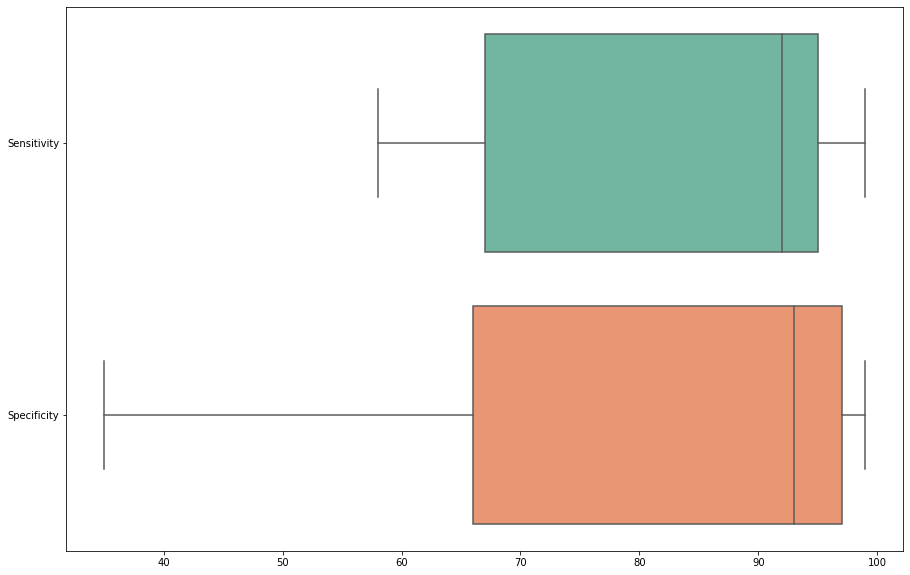

In [54]:
import seaborn as sns
performance_df = covid_litt[['Sensitivity (Clean)', 'Specificity (Clean)']]
performance_df.columns = ['Sensitivity', 'Specificity']

#Box plot for Sensitivity' and 'Specificity visualization
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=performance_df, orient="h", palette="Set2", ax=ax)
# plt.figure(figsize=(15,10))
plt.savefig("performance_box_plot.png")

In [28]:
# Article titles preprocessing
# Combine all article titles into a single string 
title_string = (" ").join(covid_litt['Title'])
# Change all title string into lower cases
title_string = title_string.lower()
# Split into words
title_tokens = word_tokenize(title_string)
# Remove punctuation (all tokens that are not alphabetic)
title_words = [word for word in title_tokens if word.isalpha()]
# Remove stopwords
title_words = [word for word in title_words if not word in stop_words]
# Perform lemmatization
# Create WordNetLemmatizer object 
wnl = WordNetLemmatizer() 
title_words = [wnl.lemmatize(word) for word in title_words]
# Re-creat filtered summary string 
title_str_final = " ".join(title_words)

In [45]:
# Article summaries preprocessing
# Combine all article abstracts into a single string 
summaries_string = (" ").join(covid_litt['Summary'])
# summaries_string2 = covid_litt['Summary']
# Change all abstract string into lower cases
summaries_string = summaries_string.lower()
# Split into words
summaries_tokens = word_tokenize(summaries_string)
# Remove punctuation (all tokens that are not alphabetic)
summaries_words = [word for word in summaries_tokens if word.isalpha()]
# Remove stopwords
summaries_words = [word for word in summaries_words if not word in stop_words]
# Perform lemmatization
# Create WordNetLemmatizer object 
# wnl = WordNetLemmatizer() # Already created in previous cell
summaries_words = [wnl.lemmatize(word) for word in summaries_words]
# Re-creat filtered summary string 
summaries_str_final = " ".join(summaries_words)

In [30]:
# Extract keywords in titles
rake_object = RAKE.Rake('SmartStoplistEdited.txt')
def ranked_keywords(tuple):
    tuple.sort(key = lambda x: x[1])
    tuple.reverse()
    return tuple
title_keywords = ranked_keywords(rake_object.run(title_string))
# Create datafram with tuples of keywords
title_keywords_df = pd.DataFrame(title_keywords, columns =['Keywords', 'Score']) 
# Save keywords dataframe to Excel
title_keywords_df.to_excel(r'Covid rdt litterature title keywords.xlsx', index = False,
                  sheet_name='title keyword')

In [31]:
title_keywords_df.head(10)

,Keywords,Score
0,ultra-rapid real-time rt-pcr method,38.383333
1,multi-target lateral flow immunoassay enabling,32.000000
2,antigen-detecting point-of-care diagnostic test,31.309384
3,primary healthcare centers real-life validation,30.416667
4,roche/sd biosensor rapid antigen test,30.195098
5,point-of-care lateral flow immunoassays,27.880952
6,rapid igm-igg combined antibody test,27.019444
7,rapid point-of-care antibody test,26.789286
8,rapid igm-igg combined antibody tests,26.569444
9,single italian center study sars-cov-,25.049158


In [46]:
# Extract keywords in abstracts
# rake_object = RAKE.Rake('SmartStoplist.txt') # Already created in previous cell
# def ranked_keywords(tuple): # ranked_keywords class already created
    # tuple.sort(key = lambda x: x[1])
    # tuple.reverse()
    # return tuple
summaries_keywords = ranked_keywords(rake_object.run(summaries_string))
# Create datafram with tuples of keywords
summaries_keywords_df = pd.DataFrame(summaries_keywords, columns =['Keywords', 'Score']) 
# Save keywords dataframe to Excel
summaries_keywords_df.to_excel(r'Covid rdt litterature summaries keywords.xlsx', index = False,
                  sheet_name='summaries keyword')

In [47]:
summaries_keywords_df.head(10)

,Keywords,Score
0,colloidal gold-labeled mouse-antihuman lgm/lgg...,47.722222
1,well-established high-throughput bench-top sol...,38.648148
2,real-time reverse transcription-polymerase cha...,35.181735
3,real-time reverse-transcriptase polymerase cha...,33.848401
4,combining ultra-rapid real-time rt-pcr,30.625983
5,findingsthe unadjusted antibody-based crude sa...,30.192376
6,proposed fm-hcf-dlf model comprises,29.333333
7,simple point-of-care lateral flow immunoassay,28.618003
8,reverse transcription-polymerase chain reaction,27.071429
9,point-of-care lateral flow serological assays,26.854470


In [34]:
# Compute word frequencies from filtered titles and display the top ten
freq_word = [title_words.count(word) for word in title_words]
dict_word = dict(list(zip(title_words, freq_word)))

freq_word_paire = [(dict_word[key], key) for key in dict_word]
freq_word_paire.sort()
freq_word_paire.reverse()

title_freq_word = pd.DataFrame.from_dict(freq_word_paire)
title_freq_word.columns=['Frequency', 'Word'] 

In [48]:
# Compute word frequencies from filtered summaries and display the top ten
freq_word2 = [summaries_words.count(word) for word in summaries_words]
dict_word2 = dict(list(zip(summaries_words, freq_word2)))

freq_word_paire2 = [(dict_word2[key], key) for key in dict_word2]
freq_word_paire2.sort()
freq_word_paire2.reverse()

# key_value_dict = {freq_word_paire for key_value in freq_word_paire}

summary_freq_word = pd.DataFrame.from_dict(freq_word_paire2)
summary_freq_word.columns=['Frequency', 'Word'] 

In [36]:
# Save the title term frequencies dataframe to a local Excel sheet
title_freq_word.to_excel(r'Covid rdt litterature data 2.xlsx', index = False,
                  sheet_name='title term freq')

In [49]:
# Save the summary term frequencies dataframe to a local Excel sheet
summary_freq_word.to_excel(r'Covid rdt litterature data 3.xlsx', index = False,
                  sheet_name='summary term freq')

In [38]:
# Print to 10 termes in titles
title_freq_word.head(10)

,Frequency,Word
0,58,test
1,53,rapid
2,22,evaluation
3,18,antibody
4,17,infection
5,16,diagnosis
6,14,performance
7,13,diagnostic
8,13,antigen
9,12,detection


In [50]:
# Print to 10 termes in summaries
summary_freq_word.head(10)

,Frequency,Word
0,356,test
1,191,rapid
2,187,sensitivity
3,141,specificity
4,137,patient
5,125,result
6,116,assay
7,107,sample
8,105,positive
9,103,antibody


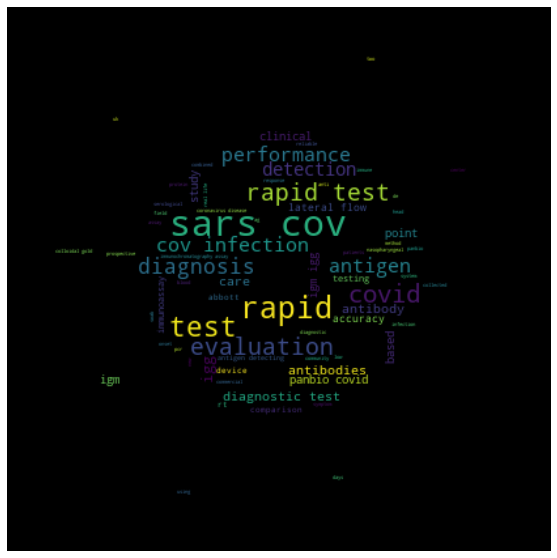

In [51]:
# Word cloud with article titles
cloud_mask = np.array(Image.open('background4.jpg'))
wordcloud = WordCloud(mask=cloud_mask).generate(title_string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("article_title_wordcloud.png", bbox_inches='tight')
plt.margins(x=0, y=0)
plt.show()

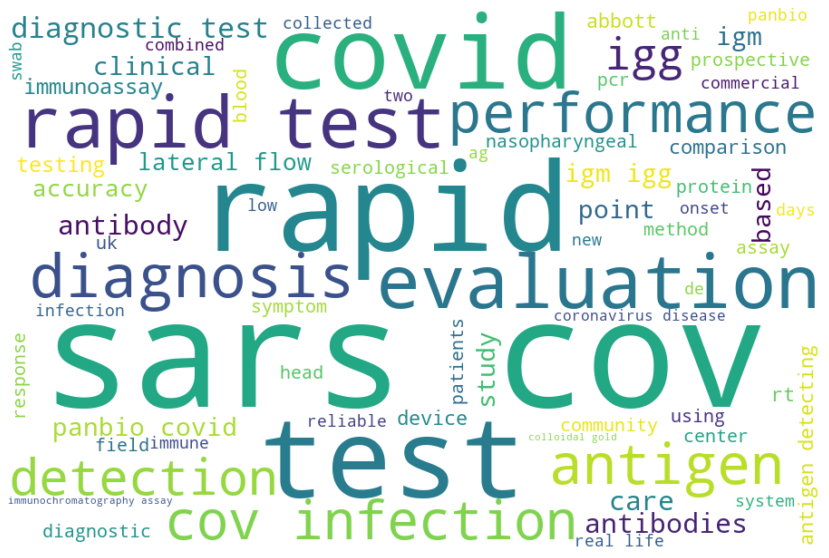

In [41]:
# Word cloud with article titles
wordcloud = WordCloud(width = 900, height = 600, 
                      background_color ='white', 
                      min_font_size = 10).generate(title_string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("article_title_wordcloud2.png", bbox_inches='tight')
plt.margins(x=0, y=0)
plt.show()

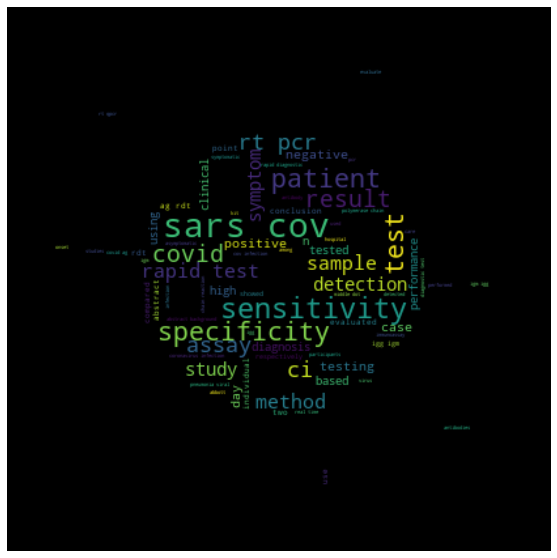

In [52]:
# Word cloud with article summaries
cloud_mask = np.array(Image.open('background4.jpg'))
# word_string = (" ").join(covid_litt['Title'])
wordcloud = WordCloud(mask=cloud_mask).generate(summaries_string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("article_summary_wordcloud.png", bbox_inches='tight')
plt.margins(x=0, y=0)
plt.show()

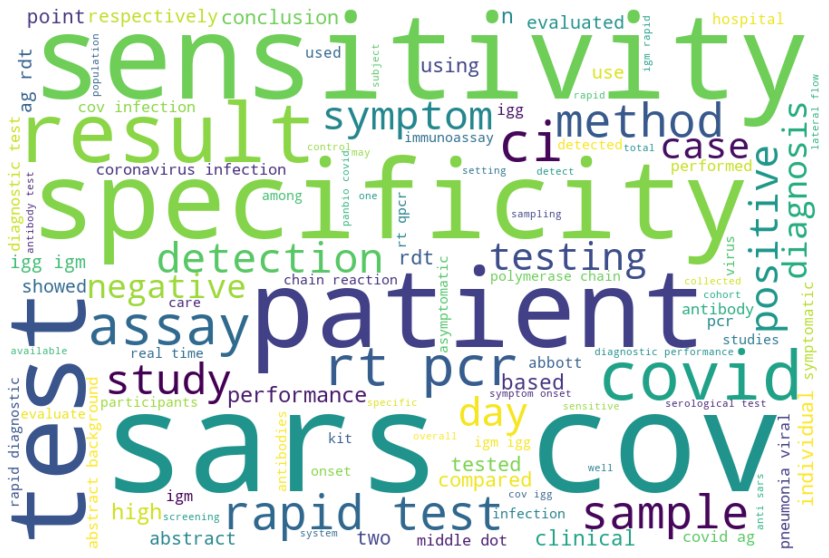

In [53]:
# Word cloud with article summaries
wordcloud = WordCloud(width = 900, height = 600, 
                      background_color ='white', 
                      min_font_size = 10).generate(summaries_string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("article_summary_wordcloud2.png", bbox_inches='tight')
plt.margins(x=0, y=0)
plt.show()